In [1]:
import pandas as pd
import numpy as np
import seaborn as sb
import re
 
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import ConfusionMatrixDisplay


import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [2]:
def first_cleaning(text):
    try:
        text = text.replace('/', ' ')
        text = text.replace('-', '_') 
        text = re.sub(r"(\:|\(|\)|\,|\*|\#|\?|=|\[|\]|\s\d\s)+", " ", text) # remove all special characters around
        text = re.sub(r"(\((\d+)+(\.\)|\)|))", " ", text) # remove all the numbers in brackets
        text = re.sub(r"(\([a-zA-Z]{1,3})\)"," ",text) # remove all text in brackets in 1-3 chars
        text = re.sub(r"([0-9]+[.,%]+)+","_value_ ",text) # remove all text in brackets in 1-3 chars   
        text = re.sub(r"(?=[^a-z]{1,}[.])(?:[a-zA-Z]|[=*,().-]|[0-9])+"," _formula_ ",text, re.M) # remove all text in brackets in 1-3 chars   
        text.replace('  ', ' ')
        return text.strip()
    except Exception as e:
        return ''

Load clean patent data + relevance data

In [3]:
data_df = pd.read_excel('./data/predictions_v2.xlsx')
data_df.pat_num = data_df.pat_num.astype(str)
data_df['clean_abstract'].fillna('', inplace=True)
data_df['clean_descritpion'].fillna('', inplace=True)
data_df['clean_claims'] = data_df['claims'].astype(str).apply(lambda x: first_cleaning(x[:6000]) if x else '') #Only bring first 6000 characters (~500-600 words)

# Concatenating abstract + description data
data_df['abs_plus_desc'] = data_df['clean_abstract'] + data_df['clean_descritpion']
data_df['abs_plus_desc_plus_claims'] = data_df['clean_abstract'] + data_df['clean_descritpion'] + data_df['clean_claims']
data_df.head()
print(data_df.shape)
data_df = data_df[data_df['relevance_model_predictions']==1]
print(data_df.shape)




(85536, 15)
(6578, 15)


Merge patent details into <b> new relevance data </b> to create training dataset

In [4]:
class_df = pd.read_csv('./data/patents_checkedagain_portability_safety_dialysis1-15-2023.csv').fillna(0)
class_df.pat_num = class_df.pat_num.astype(str)
class_df = class_df[['pat_num','portability','safety','neither portability nor saftey']]
class_df.head()

,pat_num,portability,safety,neither portability nor saftey
0,10016554,1.0,1.0,0.0
1,10022485,0.0,1.0,0.0
2,10039560,0.0,0.0,1.0
3,10039900,0.0,0.0,1.0
4,10076653,0.0,0.0,1.0


In [5]:
check_cols = ['portability', 'safety', 'neither portability nor saftey']
# Check that the 'neither' class is disjoint with the other two classes
class_df[class_df['neither portability nor saftey']==1][check_cols].sum()

portability                         0.0
safety                              0.0
neither portability nor saftey    252.0
dtype: float64

In [6]:
class_df[class_df['neither portability nor saftey']==0][check_cols].sum()

portability                       155.0
safety                            181.0
neither portability nor saftey      0.0
dtype: float64

In [7]:
#Check class overlap
class_df[class_df['portability']==1][check_cols].sum()

portability                       155.0
safety                             58.0
neither portability nor saftey      0.0
dtype: float64

In [8]:
class_df[class_df['safety']==1][check_cols].sum()

portability                        58.0
safety                            181.0
neither portability nor saftey      0.0
dtype: float64

In [9]:
class_df.describe().round(1)

,portability,safety,neither portability nor saftey
count,532.0,532.0,532.0
mean,0.3,0.3,0.5
std,0.5,0.5,0.5
min,0.0,0.0,0.0
25%,0.0,0.0,0.0
50%,0.0,0.0,0.0
75%,1.0,1.0,1.0
max,1.0,1.0,1.0


In [10]:
print(data_df.shape)
print(class_df.shape)

(6578, 15)
(532, 4)


In [11]:
training_df = data_df.merge(class_df, how='inner', on='pat_num')
training_df.shape

(513, 18)

In [12]:
training_df.columns

Index(['pat_num', 'pat_name', 'filed_date', 'inventors', 'assignee',
       'us_class', 'cpc_class', 'cited_patents', 'clean_abstract',
       'clean_descritpion', 'claims', 'relevance_model_predictions',
       'clean_claims', 'abs_plus_desc', 'abs_plus_desc_plus_claims',
       'portability', 'safety', 'neither portability nor saftey'],
      dtype='object')

In [13]:
cols = ['pat_num', 'pat_name', 'filed_date', 'us_class', 'cpc_class',
       'abs_plus_desc', 'portability', 'safety', 'neither portability nor saftey']

In [14]:
training_df[cols].head()

,pat_num,pat_name,filed_date,us_class,cpc_class,abs_plus_desc,portability,safety,neither portability nor saftey
0,3996141,Dialysis membrane,1974-01-17,210/501,A61M 1/1698 (20130101); B01D 61/30 (20130101);...,A semi_permeable membrane containing a catalys...,0.0,0.0,1.0
1,3962075,Hemo dialyzer employing two dialysate solutions,1974-04-16,210/641,A61M 1/16 (20130101); B01D 61/243 (20130101); ...,A novel dialysis system is disclosed for both ...,0.0,0.0,1.0
2,4024059,Artificial kidney,1975-04-22,210/195.2,A61M 1/1694 (20130101); A61M 1/3427 (20140204)...,An artificial kidney in which blood is pumped ...,0.0,0.0,1.0
3,4087185,Blood leak detector,1975-06-19,356/440,A61M 1/1692 (20130101); G01N 21/85 (20130101),A detector of blood in dialyzing solution whi...,0.0,1.0,0.0
4,4021341,Hemodialysis ultrafiltration system,1975-10-15,210/87,A61M 1/16 (20130101); B01D 61/145 (20130101); ...,An improved hemodialysis ultrafiltration syste...,0.0,1.0,0.0


Generate TF-IDF embeddings <b> on patent abstract + description </b>

In [36]:
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
full_corpus = data_df['abs_plus_desc'].values
training_corpus = training_df['abs_plus_desc'].values
vectorizer = TfidfVectorizer(
    lowercase=True,
    min_df = 5,
    max_df = .95,
    stop_words=gensim.parsing.preprocessing.STOPWORDS
)
vectorizer.fit(full_corpus)

TfidfVectorizer(max_df=0.95, min_df=5,
                stop_words=frozenset({'a', 'about', 'above', 'across', 'after',
                                      'afterwards', 'again', 'against', 'all',
                                      'almost', 'alone', 'along', 'already',
                                      'also', 'although', 'always', 'am',
                                      'among', 'amongst', 'amoungst', 'amount',
                                      'an', 'and', 'another', 'any', 'anyhow',
                                      'anyone', 'anything', 'anyway',
                                      'anywhere', ...}))

In [61]:
len(vectorizer.vocabulary_.keys())

15027

Train Boosted Trees Model

In [44]:
def train_model(X_train, X_val, y_train, y_val, verbosity=0):
    dtrain = xgb.DMatrix(X_train, y_train)
    dval = xgb.DMatrix(X_val, y_val)
    
    num_round = 1000
    param = {
        'max_depth': 6, 
        'eta': 0.02, 
        'objective': 'binary:logistic',
        'verbosity': 1,
        'nthread': -1, 
        'eval_metric': ['logloss'],
        'scale_pos_weight': 3
    }

    evallist = [(dval, 'eval')]
    watchlist = [(dtrain,'train'), (dval,'eval')]
    evals_result = {}
    bst = xgb.train(param, dtrain, num_round, watchlist, evals_result=evals_result,  early_stopping_rounds=15)    
    return bst

In [17]:
def plot_performance_at_t(y_true, y_pred, t_steps=10):
    for t in range(10,90,int(80/t_steps)):
        treshold = t/100
        print(treshold)
        y_pred_at_t = [1 if y>=treshold else 0 for y in y_pred]
        print(precision_recall_fscore_support(y_true, y_pred_at_t, average='binary'))

        ConfusionMatrixDisplay.from_predictions(y_true, y_pred_at_t)
        plt.show()

In [40]:
import xgboost as xgb

X = vectorizer.transform(training_df['abs_plus_desc']).toarray()
y = training_df['portability']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.3, random_state=42)

In [41]:
print(X_train.shape)
print(y_train.describe())
print('-------------')
print(X_test.shape)
print(y_test.describe())

(359, 15027)
count    359.00000
mean       0.29805
std        0.45804
min        0.00000
25%        0.00000
50%        0.00000
75%        1.00000
max        1.00000
Name: portability, dtype: float64
-------------
(107, 15027)
count    107.000000
mean       0.271028
std        0.446582
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: portability, dtype: float64


[0]	train-logloss:0.67706	eval-logloss:0.68290
[1]	train-logloss:0.66194	eval-logloss:0.67163
[2]	train-logloss:0.64736	eval-logloss:0.66116
[3]	train-logloss:0.63317	eval-logloss:0.65170
[4]	train-logloss:0.61957	eval-logloss:0.64139
[5]	train-logloss:0.60644	eval-logloss:0.63218
[6]	train-logloss:0.59363	eval-logloss:0.62421
[7]	train-logloss:0.58147	eval-logloss:0.61402
[8]	train-logloss:0.56957	eval-logloss:0.60546
[9]	train-logloss:0.55796	eval-logloss:0.59513
[10]	train-logloss:0.54679	eval-logloss:0.58722
[11]	train-logloss:0.53609	eval-logloss:0.57930
[12]	train-logloss:0.52559	eval-logloss:0.57202
[13]	train-logloss:0.51553	eval-logloss:0.56466
[14]	train-logloss:0.50564	eval-logloss:0.55841
[15]	train-logloss:0.49594	eval-logloss:0.54995
[16]	train-logloss:0.48662	eval-logloss:0.54360
[17]	train-logloss:0.47752	eval-logloss:0.53621
[18]	train-logloss:0.46861	eval-logloss:0.53135
[19]	train-logloss:0.45995	eval-logloss:0.52692
[20]	train-logloss:0.45171	eval-logloss:0.52020
[2

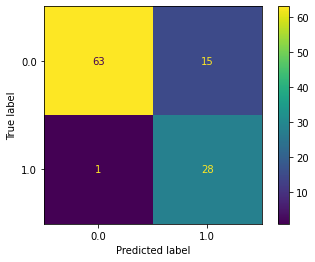

0.18
(0.7297297297297297, 0.9310344827586207, 0.8181818181818181, None)


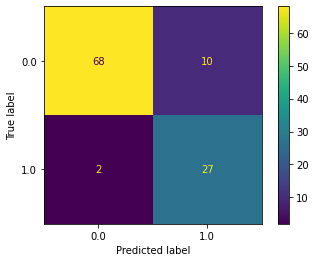

0.26
(0.7714285714285715, 0.9310344827586207, 0.8437500000000001, None)


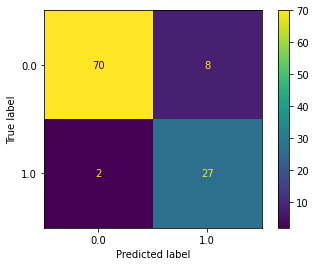

0.34
(0.7878787878787878, 0.896551724137931, 0.8387096774193549, None)


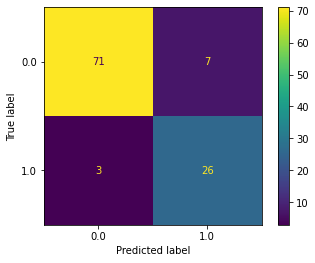

0.42
(0.8125, 0.896551724137931, 0.8524590163934426, None)


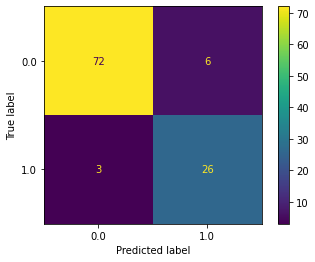

0.5
(0.8620689655172413, 0.8620689655172413, 0.8620689655172413, None)


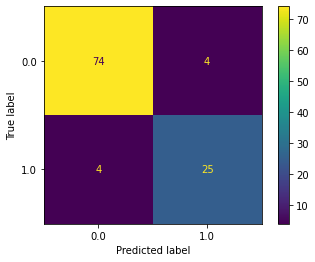

0.58
(0.8928571428571429, 0.8620689655172413, 0.8771929824561403, None)


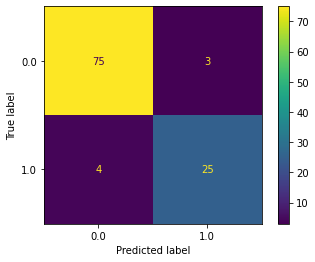

0.66
(0.9259259259259259, 0.8620689655172413, 0.8928571428571429, None)


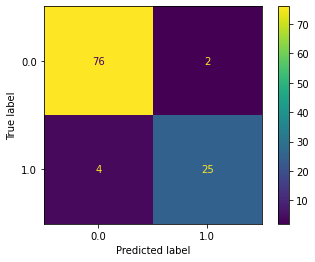

0.74
(0.9259259259259259, 0.8620689655172413, 0.8928571428571429, None)


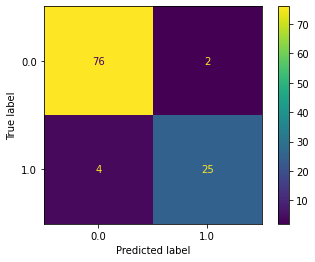

0.82
(0.9230769230769231, 0.8275862068965517, 0.8727272727272727, None)


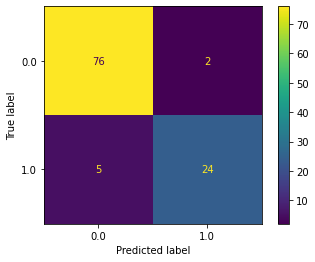

In [45]:
portability_clf = train_model(X_train, X_val, y_train, y_val, verbosity=1)
dtest = xgb.DMatrix(X_test)
y_pred = portability_clf.predict(dtest)
y_true = y_test
plot_performance_at_t(y_true, y_pred, 10)

In [47]:
import xgboost as xgb

X = vectorizer.transform(training_df['abs_plus_desc_plus_claims']).toarray()
y = training_df['safety']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.3, random_state=42)

In [48]:
print(X_train.shape)
print(y_train.describe())
print('-------------')
print(X_test.shape)
print(y_test.describe())

(359, 15027)
count    359.000000
mean       0.300836
std        0.459261
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: safety, dtype: float64
-------------
(107, 15027)
count    107.000000
mean       0.383178
std        0.488449
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: safety, dtype: float64


[0]	train-logloss:0.67907	eval-logloss:0.68606
[1]	train-logloss:0.66553	eval-logloss:0.67774
[2]	train-logloss:0.65208	eval-logloss:0.67023
[3]	train-logloss:0.63913	eval-logloss:0.66127
[4]	train-logloss:0.62677	eval-logloss:0.65686
[5]	train-logloss:0.61423	eval-logloss:0.64820
[6]	train-logloss:0.60193	eval-logloss:0.64022
[7]	train-logloss:0.59047	eval-logloss:0.63293
[8]	train-logloss:0.57924	eval-logloss:0.62762
[9]	train-logloss:0.56753	eval-logloss:0.62070
[10]	train-logloss:0.55709	eval-logloss:0.61369
[11]	train-logloss:0.54679	eval-logloss:0.60789
[12]	train-logloss:0.53694	eval-logloss:0.60244
[13]	train-logloss:0.52664	eval-logloss:0.59617
[14]	train-logloss:0.51665	eval-logloss:0.59018
[15]	train-logloss:0.50768	eval-logloss:0.58592
[16]	train-logloss:0.49816	eval-logloss:0.58040
[17]	train-logloss:0.48967	eval-logloss:0.57639
[18]	train-logloss:0.48152	eval-logloss:0.57212
[19]	train-logloss:0.47269	eval-logloss:0.56729
[20]	train-logloss:0.46486	eval-logloss:0.56358
[2

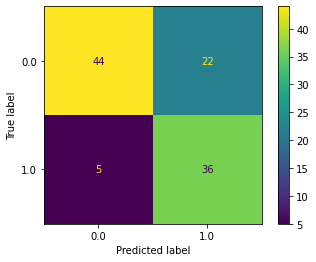

0.18
(0.6530612244897959, 0.7804878048780488, 0.711111111111111, None)


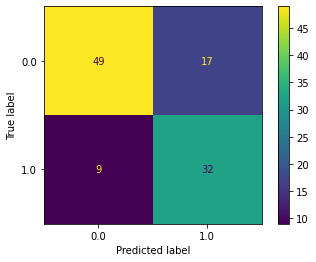

0.26
(0.7142857142857143, 0.7317073170731707, 0.7228915662650603, None)


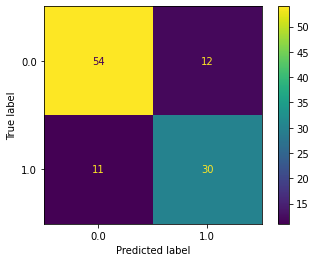

0.34
(0.7368421052631579, 0.6829268292682927, 0.7088607594936709, None)


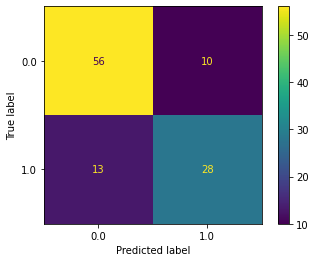

0.42
(0.7777777777777778, 0.6829268292682927, 0.7272727272727273, None)


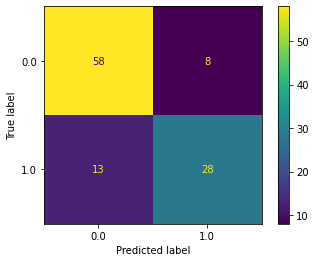

0.5
(0.7647058823529411, 0.6341463414634146, 0.6933333333333332, None)


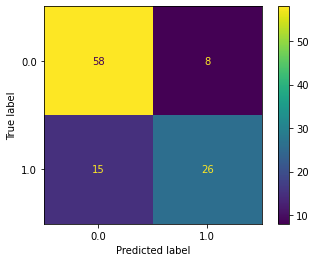

0.58
(0.7741935483870968, 0.5853658536585366, 0.6666666666666666, None)


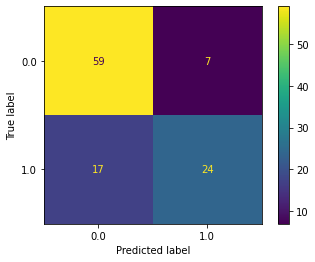

0.66
(0.8518518518518519, 0.5609756097560976, 0.6764705882352942, None)


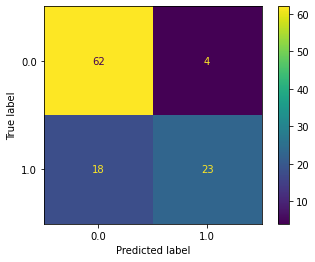

0.74
(0.88, 0.5365853658536586, 0.6666666666666667, None)


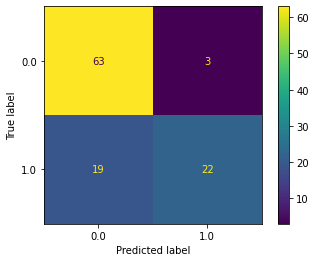

0.82
(0.875, 0.5121951219512195, 0.6461538461538462, None)


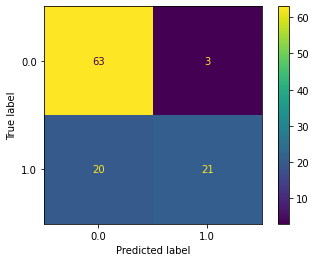

In [49]:
portability_clf_w_claims = train_model(X_train, X_val, y_train, y_val, verbosity=1)
dtest = xgb.DMatrix(X_test)
y_pred = portability_clf_w_claims.predict(dtest)
y_true = y_test
plot_performance_at_t(y_true, y_pred, 10)

In [50]:
X = vectorizer.transform(training_df['abs_plus_desc']).toarray()
y = training_df['safety']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.3, random_state=42)

[0]	train-logloss:0.67852	eval-logloss:0.68222
[1]	train-logloss:0.66475	eval-logloss:0.67431
[2]	train-logloss:0.65127	eval-logloss:0.66529
[3]	train-logloss:0.63815	eval-logloss:0.65561
[4]	train-logloss:0.62570	eval-logloss:0.64737
[5]	train-logloss:0.61344	eval-logloss:0.63985
[6]	train-logloss:0.60160	eval-logloss:0.63215
[7]	train-logloss:0.59030	eval-logloss:0.62429
[8]	train-logloss:0.57914	eval-logloss:0.61755
[9]	train-logloss:0.56867	eval-logloss:0.61086
[10]	train-logloss:0.55813	eval-logloss:0.60378
[11]	train-logloss:0.54800	eval-logloss:0.59678
[12]	train-logloss:0.53805	eval-logloss:0.59021
[13]	train-logloss:0.52854	eval-logloss:0.58363
[14]	train-logloss:0.51951	eval-logloss:0.57774
[15]	train-logloss:0.51044	eval-logloss:0.57279
[16]	train-logloss:0.50179	eval-logloss:0.56814
[17]	train-logloss:0.49336	eval-logloss:0.56371
[18]	train-logloss:0.48518	eval-logloss:0.55831
[19]	train-logloss:0.47727	eval-logloss:0.55397
[20]	train-logloss:0.46933	eval-logloss:0.54889
[2

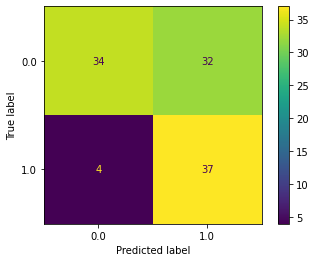

0.18
(0.5961538461538461, 0.7560975609756098, 0.6666666666666667, None)


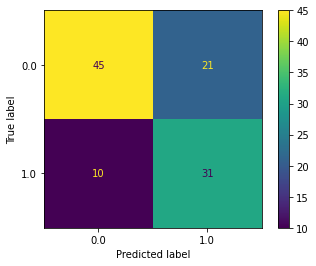

0.26
(0.6086956521739131, 0.6829268292682927, 0.6436781609195402, None)


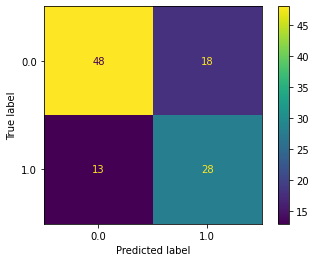

0.34
(0.6222222222222222, 0.6829268292682927, 0.6511627906976744, None)


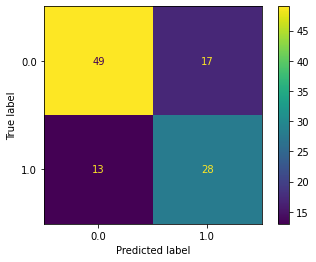

0.42
(0.6428571428571429, 0.6585365853658537, 0.6506024096385543, None)


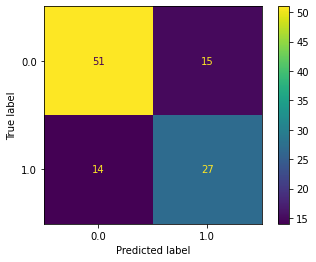

0.5
(0.6578947368421053, 0.6097560975609756, 0.6329113924050632, None)


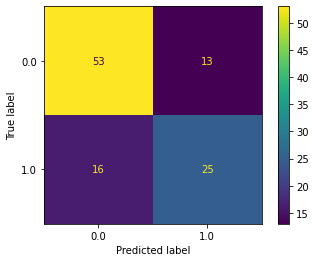

0.58
(0.6857142857142857, 0.5853658536585366, 0.6315789473684211, None)


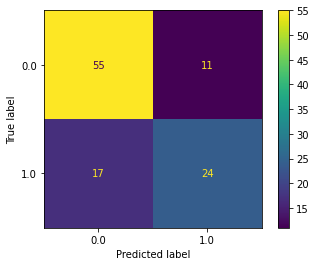

0.66
(0.7857142857142857, 0.5365853658536586, 0.6376811594202899, None)


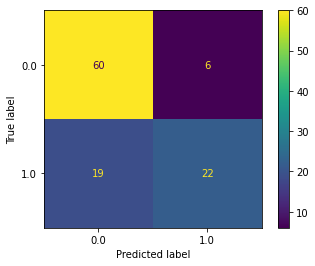

0.74
(0.7916666666666666, 0.4634146341463415, 0.5846153846153846, None)


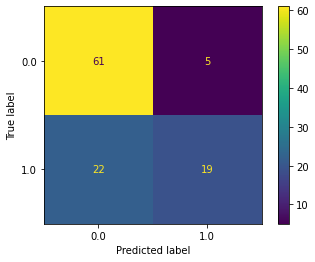

0.82
(0.875, 0.34146341463414637, 0.4912280701754386, None)


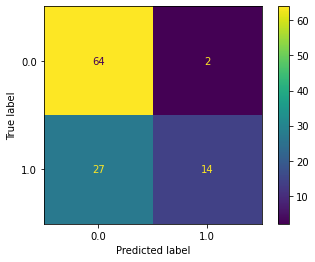

In [51]:
safety_clf = train_model(X_train, X_val, y_train, y_val, verbosity=1)
dtest = xgb.DMatrix(X_test)
y_pred = safety_clf.predict(dtest)
plot_performance_at_t(y_true, y_pred, 10)

In [53]:
X = vectorizer.transform(training_df['abs_plus_desc_plus_claims']).toarray()
y = training_df['safety']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

X_test, X_val, y_test, y_val = train_test_split(
    X_test, y_test, test_size=0.3, random_state=42)

[0]	train-logloss:0.67907	eval-logloss:0.68606
[1]	train-logloss:0.66553	eval-logloss:0.67774
[2]	train-logloss:0.65208	eval-logloss:0.67023
[3]	train-logloss:0.63913	eval-logloss:0.66127
[4]	train-logloss:0.62677	eval-logloss:0.65686
[5]	train-logloss:0.61423	eval-logloss:0.64820
[6]	train-logloss:0.60193	eval-logloss:0.64022
[7]	train-logloss:0.59047	eval-logloss:0.63293
[8]	train-logloss:0.57924	eval-logloss:0.62762
[9]	train-logloss:0.56753	eval-logloss:0.62070
[10]	train-logloss:0.55709	eval-logloss:0.61369
[11]	train-logloss:0.54679	eval-logloss:0.60789
[12]	train-logloss:0.53694	eval-logloss:0.60244
[13]	train-logloss:0.52664	eval-logloss:0.59617
[14]	train-logloss:0.51665	eval-logloss:0.59018
[15]	train-logloss:0.50768	eval-logloss:0.58592
[16]	train-logloss:0.49816	eval-logloss:0.58040
[17]	train-logloss:0.48967	eval-logloss:0.57639
[18]	train-logloss:0.48152	eval-logloss:0.57212
[19]	train-logloss:0.47269	eval-logloss:0.56729
[20]	train-logloss:0.46486	eval-logloss:0.56358
[2

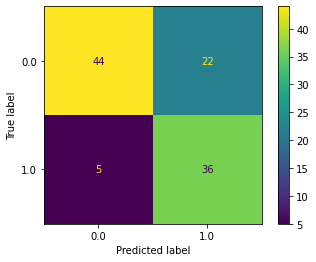

0.18
(0.6530612244897959, 0.7804878048780488, 0.711111111111111, None)


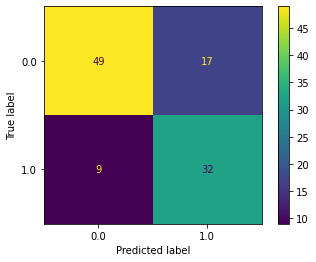

0.26
(0.7142857142857143, 0.7317073170731707, 0.7228915662650603, None)


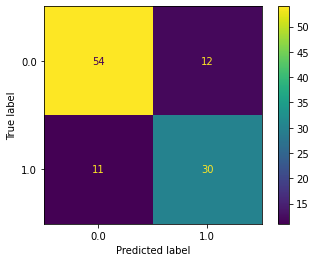

0.34
(0.7368421052631579, 0.6829268292682927, 0.7088607594936709, None)


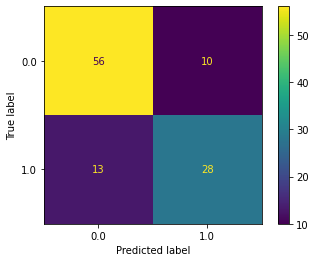

0.42
(0.7777777777777778, 0.6829268292682927, 0.7272727272727273, None)


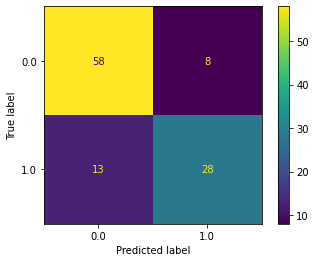

0.5
(0.7647058823529411, 0.6341463414634146, 0.6933333333333332, None)


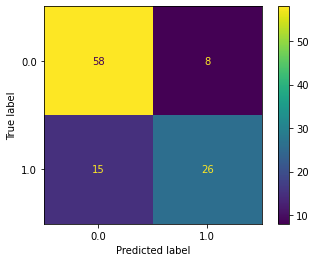

0.58
(0.7741935483870968, 0.5853658536585366, 0.6666666666666666, None)


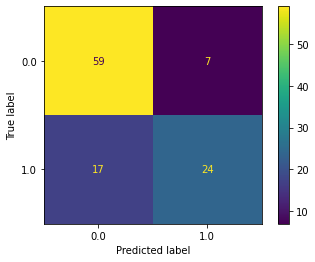

0.66
(0.8518518518518519, 0.5609756097560976, 0.6764705882352942, None)


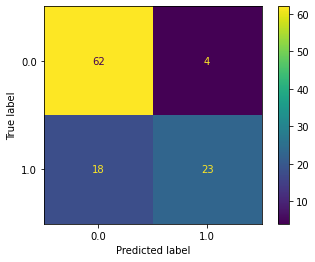

0.74
(0.88, 0.5365853658536586, 0.6666666666666667, None)


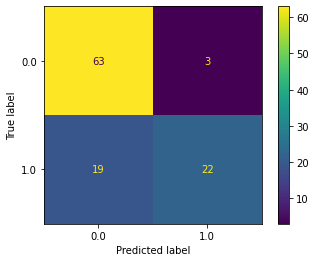

0.82
(0.875, 0.5121951219512195, 0.6461538461538462, None)


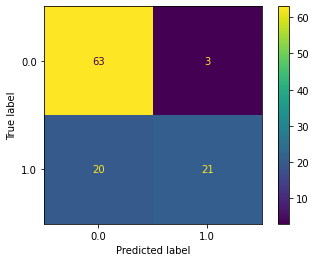

In [54]:
safety_clf_w_claims = train_model(X_train, X_val, y_train, y_val, verbosity=1)
dtest = xgb.DMatrix(X_test)
y_pred = safety_clf_w_claims.predict(dtest)
plot_performance_at_t(y_true, y_pred, 10)

In [56]:
training_ids = set(training_df.pat_num)
len(training_ids)

505

In [57]:
print(data_df.shape)
in_scope_df = data_df[~data_df.pat_num.isin(training_ids)]
print(in_scope_df.shape)

(6578, 15)
(6073, 15)


In [58]:
dtest = xgb.DMatrix(vectorizer.transform(in_scope_df['abs_plus_desc_plus_claims']).toarray())
pred_y = portability_clf_w_claims.predict(dtest)
in_scope_df['portability_proba'] = pred_y
#in_scope_df['portability_pred'] = [1 if y > portability_treshold else 0 for y in pred_y]

pred_y = safety_clf_w_claims.predict(dtest)
in_scope_df['safety_proba'] = pred_y
#in_scope_df['safety_pred'] = [1 if y > safety_treshold else 0 for y in pred_y]

<AxesSubplot:xlabel='portability_proba', ylabel='Density'>

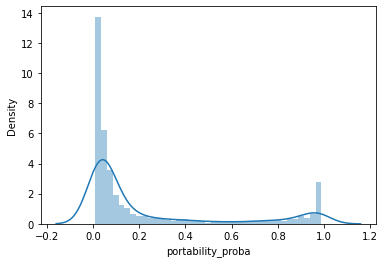

In [91]:
sb.distplot(in_scope_df['portability_proba'])

<AxesSubplot:xlabel='safety_proba', ylabel='Density'>

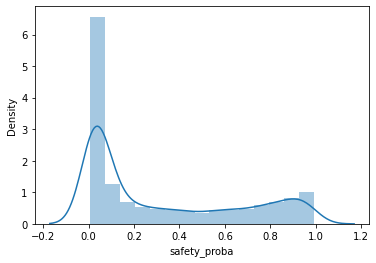

In [114]:
sb.distplot(in_scope_df['safety_proba'])

In [94]:
in_scope_df.to_excel('portability_safety_with_probs_6000_patents.xlsx', index=False)

In [ ]:
import joblib
joblib.dump(safety_clf,'clf_safety_jan_18_2023.joblib')
joblib.dump(portability_clf,'clf_portability_jan_18_2023.joblib')